<img src="https://github.com/gantian127/bmi_nwis/blob/master/docs/source/_static/bmi_nwis_logo.png?raw=true" width='450' align='center'></a>

## Basic Info
This Jupyter Notebook was created by Tian Gan. You can test this Jupyter Notebook through [Binder](https://mybinder.org/v2/gh/gantian127/bmi_nwis/master?filepath=notebooks%2Fbmi_nwis.ipynb) or [HydroShare](https://www.hydroshare.org/resource/1473ac1368b44808b57cca2848923779/).

If you have any suggestion to improve the current functions of the bmi_nwis package, please create a github issue [here](https://github.com/gantian127/bmi_nwis/issues).

Suggested citation: Gan, T. (2022). Jupyter Notebooks for the NWIS Data Component, HydroShare, https://www.hydroshare.org/resource/1473ac1368b44808b57cca2848923779/

## Quick Start Tutorial 

This notebook will help you get started using the bmi_nwis package to download the National Water Information System (NWIS) datasets. 

This tutorial includes the following sections:

1. [Brief Introduction](#section1)

   This section provides basic information about bmi_nwis package. 
   <br>
   
2. [Start with Examples](#section2)
   
   This section provides two examples to demonstrate how to use the dataretrieval package and bmi_nwis package to download the same NWIS dataset for visualization.

<a id='section1'></a>
## 1. Brief Introduction

bmi_nwis package is an implementation of the Basic Model Interface ([BMI](https://bmi-spec.readthedocs.io/en/latest/)) for the [USGS NWIS dataset](https://waterdata.usgs.gov/nwis). 
This package uses the [dataretrieval](https://github.com/USGS-python/dataretrieval) package 
to download the NWIS dataset and wraps the dataset with BMI for data control and query. This package is not implemented for people to use but is the key element to convert the NWIS dataset into a data component ([pymt_nwis](https://github.com/gantian127/pymt_nwis)) for 
the [PyMT](https://pymt.readthedocs.io/en/latest/?badge=latest) modeling framework developed by Community Surface Dynamics Modeling System ([CSDMS](https://csdms.colorado.edu/wiki/Main_Page)).

Please note that the current bmi_nwis implementation only supports to download time series data 
for instantaneous values and daily mean values ('iv' or 'dv' service option in the dataretrieval package).

To install bmi_nwis package, you can use the following command:

In [ ]:
! pip install bmi_nwis

<a id='section2'></a>
## 2. Start with Examples

The dataretrieval package is a Python alternative to USGS-R's dataRetrieval package for obtaining research datasets from web services. 

In bmi_nwis package, BmiNwis class is designed to download the USGS NWIS dataset using dataretrieval package and wrap the dataset with BMI. Please note that the current bmi_nwis implementation only supports to download time series data for instantaneous values and daily mean values ('iv' or 'dv' service option in the dataretrieval package). 

The following examples demonstrate how to download the same dataset using the dataretrieval package and BmiNwis for data visualization. 

### Example 1: use the dataretrieval package to download data

In this example, get_record( ) function from the dataretrieval package is used to download the instantaneous datasets at the USGS Gage [03339000](https://waterdata.usgs.gov/nwis/uv?site_no=03339000) from Jan 1st to 3rd, 2022. Time series plots of stream flow and gage height are created. 

Text(0, 0.5, 'Gage height (ft)')

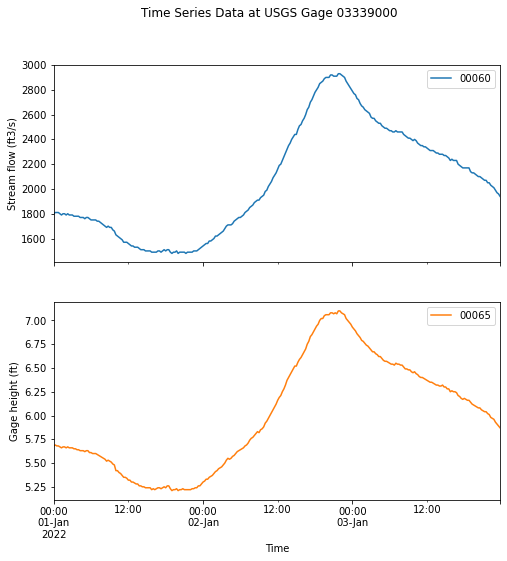

In [1]:
import dataretrieval.nwis as nwis                                 

# get data from NWIS
dataset = nwis.get_record(sites='03339000', service='iv', start='2022-01-01', end='2022-01-03')

# plot data
ax = dataset.plot(y=['00060','00065'], subplots=True, figsize=(8,8), 
                  xlabel='Time', title = 'Time Series Data at USGS Gage 03339000')
ax[0].set_ylabel('Stream flow (ft3/s)')
ax[1].set_ylabel('Gage height (ft)')


### Example 2: use BmiNwis class to download data (Demonstration of how to use BMI)

Import BmiNwis class and instantiate it. A configuration file (yaml file) is required to provide the [parameter settings](https://bmi_nwis.readthedocs.io/en/latest/#parameter-settings) for data download. An example configure_file.yaml file is provided in the same folder with this Jupyter Notebook file. 

In [2]:
import numpy as np
import cftime
import pandas as pd

from bmi_nwis import BmiNwis


# initiate a data component
data_comp = BmiNwis()
data_comp.initialize('config_file.yaml')

Use variable related methods from BmiNwis class to check the variable information of the NWIS dataset. This data component stores multiple variables, including discharge, gage height, and water temperature. 

In [3]:
# get variable info
for var_name in  data_comp.get_output_var_names():
    var_unit = data_comp.get_var_units(var_name)
    var_location = data_comp.get_var_location(var_name)
    var_type = data_comp.get_var_type(var_name)
    var_grid = data_comp.get_var_grid(var_name)
    var_itemsize = data_comp.get_var_itemsize(var_name)
    var_nbytes = data_comp.get_var_nbytes(var_name)
    print('variable_name: {} \nvar_unit: {} \nvar_location: {} \nvar_type: {} \nvar_grid: {} \nvar_itemsize: {}' 
            '\nvar_nbytes: {} \n'. format(var_name, var_unit, var_location, var_type, var_grid, var_itemsize, var_nbytes))

variable_name: Inorganic nitrogen (nitrate and nitrite) 
var_unit: lb/d as N 
var_location: node 
var_type: float64 
var_grid: 0 
var_itemsize: 8
var_nbytes: 8 

variable_name: Stream flow 
var_unit: ft3/s 
var_location: node 
var_type: float64 
var_grid: 0 
var_itemsize: 8
var_nbytes: 8 

variable_name: Height 
var_unit: ft 
var_location: node 
var_type: float64 
var_grid: 0 
var_itemsize: 8
var_nbytes: 8 

variable_name: Turbidity 
var_unit: FNU 
var_location: node 
var_type: float64 
var_grid: 0 
var_itemsize: 8
var_nbytes: 8 



Use time related methods of BmiNwis class to check the time information of the NWIS dataset. The time values are stored in a format which follows [CF convention](http://cfconventions.org/Data/cf-conventions/cf-conventions-1.8/cf-conventions.pdf). 

In [4]:
start_time = data_comp.get_start_time()
end_time = data_comp.get_end_time()
time_step = data_comp.get_time_step()
time_unit = data_comp.get_time_units()
time_steps = int((end_time - start_time)/time_step) + 1
print('start_time:{} \nend_time:{} \ntime_step:{} \ntime_unit:{} \ntime_steps:{} \n'.format(start_time, end_time, time_step, time_unit, time_steps))

start_time:1641016800.0 
end_time:1641275100.0 
time_step:900.0 
time_unit:seconds since 1970-01-01 00:00:00 UTC 
time_steps:288 



Use grid related methods to check the grid information of the NWIS dataset.

In [5]:
# get variable grid info
grid_type = data_comp.get_grid_type(var_grid)
grid_rank = data_comp.get_grid_rank(var_grid) 
grid_node_count = data_comp.get_grid_node_count(var_grid)

site_lon = np.empty(grid_node_count)
data_comp.get_grid_x(var_grid, site_lon)

site_lat = np.empty(grid_node_count)
data_comp.get_grid_y(var_grid, site_lat)

print('grid_type: {} \ngrid_rank: {} \ngrid_node_count: {} \nsite_lon: {} \nsite_lat: {}'.format(
    grid_type, grid_rank, grid_node_count, site_lon[0], site_lat[0]))

grid_type: points 
grid_rank: 2 
grid_node_count: 1 
site_lon: -87.5972419 
site_lat: 40.10087009


Initiate a dataframe to store the time series data. Loop through each time step to get the stream flow, gage height and time values. get_value( ) method returns the stream flow and gage height values at each time step. update( ) method updates the current time step of the data component. 

In [6]:
# initiate dataframe to store data
dataset = pd.DataFrame(columns = ['00060','00065','time'])

for i in range(0, time_steps):
    # get stream flow data
    stream_flow = np.empty(1)
    data_comp.get_value('Stream flow', stream_flow)
    
    # get gage height data
    gage_height = np.empty(1)
    data_comp.get_value('Height', gage_height)
    
    # get time data
    cftime_value= data_comp.get_current_time()   
    time = cftime.num2pydate(cftime_value, time_unit)
    
    # add new row to dataframe
    dataset.loc[len(dataset)]=[stream_flow[0], gage_height[0], time]
    
    # update to next time step
    data_comp.update()
    
# convert time to local time
dataset = dataset.set_index('time').tz_localize(tz='UTC').tz_convert(tz='US/Central')

Text(0, 0.5, 'Gage height (ft)')

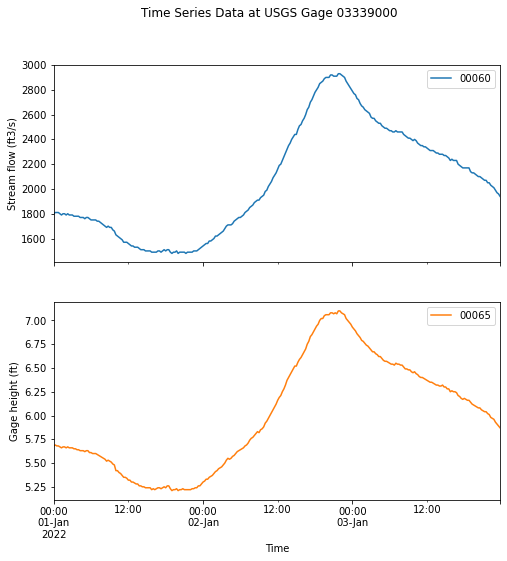

In [7]:
# plot data
ax = dataset.plot(y=['00060','00065'], subplots=True, figsize=(8,8), 
                  xlabel='Time', title = 'Time Series Data at USGS Gage 03339000')
ax[0].set_ylabel('Stream flow (ft3/s)')
ax[1].set_ylabel('Gage height (ft)')

Complete the example by finalizing the component. finalize( ) method performs tasks that take place after using the data component, such as deallocating memory and closing files.

In [8]:
data_comp.finalize()